In [1]:
%reload_ext autoreload
%autoreload 2

from lib.basis import construct_rotation_matrix
from lib.formatting import bitstring_to_int
from lib.data_loading import load_measurements, MultiBasisDataLoader
from lib.state_io import load_state_vector

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence, Callable

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn
from jaxtyping import PyTree

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506110124_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506110124_0


In [14]:
from flax import linen as nn
import jax
import jax.numpy as jnp
from typing import Tuple

class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int
    n_fourier_terms: int = 16

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)

        self.W_amp = self.variable('amp', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp', 'c_amp', zeros, (self.n_hidden,))

        self.w_pha = self.param('w_pha', nn.initializers.normal(0.1), (self.n_fourier_terms, self.n_visible))
        self.a_pha = self.param('a_pha', nn.initializers.normal(0.01), (self.n_fourier_terms,))
        self.b_pha = self.param('b_pha', nn.initializers.normal(0.01), (self.n_fourier_terms,))
        self.c_pha = self.param('c_pha', nn.initializers.normal(0.01), (self.n_fourier_terms,))
        self.d_pha = self.param('d_pha', nn.initializers.normal(0.01), (self.n_fourier_terms,))

    def _free_energy_amp(self, v):
        return -(v @ self.b_amp.value) - jnp.sum(jax.nn.softplus(v @ self.W_amp.value + self.c_amp.value), -1)

    def _free_energy_pha(self, v):
        # Fourier-style phase energy
        proj = v @ self.w_pha.T  # (batch, n_terms)
        sin_part = self.a_pha * jnp.sin(proj + self.b_pha)
        cos_part = self.c_pha * jnp.cos(proj + self.d_pha)
        return jnp.sum(sin_part + cos_part, axis=-1)

    def compute_phase(self, v: jnp.ndarray) -> jnp.ndarray:
        return -self._free_energy_pha(v)

    @staticmethod
    def rotated_log_prob(rotation_weights, free_energy_lambda, free_energy_mu):
        computational_log_magnitudes = -0.5 * free_energy_lambda
        computational_phases = -0.5j * free_energy_mu

        max_log_magnitude = jnp.max(computational_log_magnitudes)
        scaled_amplitudes = jnp.exp(computational_log_magnitudes - max_log_magnitude + computational_phases)

        scaled_measurement_amplitude = jnp.vdot(rotation_weights, scaled_amplitudes)
        log_measurement_amplitude = max_log_magnitude + jnp.log(jnp.abs(scaled_measurement_amplitude) + 1e-30)
        return 2 * log_measurement_amplitude

    def __call__(self, measurement_tuple: Tuple) -> jnp.ndarray:
        measurement, basis = measurement_tuple
        local_indices = jnp.array(jnp.nonzero(basis != 0, size=2, fill_value=-1)[0])

        local_rotation_matrix = construct_rotation_matrix(basis[local_indices])
        local_rotation_weights = local_rotation_matrix[bitstring_to_int(measurement[local_indices])]

        local_measurement_combos = jnp.array([[0,0], [0,1], [1,0], [1,1]], dtype=measurement.dtype)
        local_basis_vectors = jnp.tile(measurement, (4, 1)).at[:, local_indices].set(local_measurement_combos)

        free_energy_lambda = self._free_energy_amp(local_basis_vectors)
        free_energy_mu = self._free_energy_pha(local_basis_vectors)

        return self.rotated_log_prob(local_rotation_weights, free_energy_lambda, free_energy_mu)

In [15]:
def full_basis_loss(
        params: PyTree,
        apply_fn: Callable,
        amp_vars: Dict[str, jnp.ndarray],
        data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:

    basis_measurements, bases = data_tuple

    single_sample_loss = lambda m, b: apply_fn({'params': params, 'amp': amp_vars}, (m, b))
    single_basis_loss = lambda ms, b: jnp.mean(jax.vmap(lambda m: single_sample_loss(m, b))(ms))

    return -jnp.sum(jax.vmap(lambda ms, b: single_basis_loss(ms, b))(basis_measurements, bases))


@jax.jit
def train_step_sgd(state: TrainState, amp_vars: dict, data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> Tuple[TrainState, jnp.ndarray]:
    loss_fn = lambda params: full_basis_loss(params, state.apply_fn, amp_vars, data_tuple)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss


def train_rbm_pha(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",
        num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[str, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:
            state, loss = train_step_sgd(state, amp_vars, data_tuple)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(loss=avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f}")

    return state, metrics

In [16]:
data_dict = load_measurements(data_dir, "w_*.txt")

keys_pha = [k for k in data_dict if 'Z' in k and re.search(r'[XY]', k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [17]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

In [18]:
import jax.numpy as jnp

# Inspect magnitude of loaded amplitude weights
for name, var in amp_vars.items():
    l2 = jnp.linalg.norm(var)
    l1 = jnp.sum(jnp.abs(var))
    print(f"{name}: L2 norm = {l2:.4f}, L1 norm = {l1:.4f}")

W_amp: L2 norm = 134.8981, L1 norm = 1195.3207
b_amp: L2 norm = 11.4889, L1 norm = 29.3447
c_amp: L2 norm = 41.3537, L1 norm = 109.6289


In [19]:
batch_size    = 6400
visible_units = 8
hidden_units  = 16
num_epochs    = 3000
init_lr       = 1e-3
weight_decay  = 1e-5

key = jax.random.PRNGKey(0)

model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)

dummy_meas  = jnp.zeros((visible_units,), dtype=jnp.float32)
dummy_basis = jnp.zeros((visible_units,), dtype=jnp.int8)

vars_pha = model_pha.init(key, (dummy_meas, dummy_basis))

optim = optax.adamw(init_lr, weight_decay=weight_decay)

state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=optim)

loader_pha = MultiBasisDataLoader(dict_pha, batch_size=batch_size, basis_encoding={'Z': 0, 'X': 1, 'Y': 2}, shuffle=True)

%time state_pha, metrics_pha = train_rbm_pha(state_pha, amp_vars, loader_pha, num_epochs)

Epoch 1/3000 │ Loss: -136.8791
Epoch 2/3000 │ Loss: -136.8846
Epoch 3/3000 │ Loss: -136.8918
Epoch 4/3000 │ Loss: -136.9008
Epoch 5/3000 │ Loss: -136.9116
Epoch 6/3000 │ Loss: -136.9240
Epoch 7/3000 │ Loss: -136.9379
Epoch 8/3000 │ Loss: -136.9532
Epoch 9/3000 │ Loss: -136.9696
Epoch 10/3000 │ Loss: -136.9871
Epoch 11/3000 │ Loss: -137.0055
Epoch 12/3000 │ Loss: -137.0247
Epoch 13/3000 │ Loss: -137.0445
Epoch 14/3000 │ Loss: -137.0648
Epoch 15/3000 │ Loss: -137.0855
Epoch 16/3000 │ Loss: -137.1064
Epoch 17/3000 │ Loss: -137.1275
Epoch 18/3000 │ Loss: -137.1487
Epoch 19/3000 │ Loss: -137.1699
Epoch 20/3000 │ Loss: -137.1911
Epoch 21/3000 │ Loss: -137.2123
Epoch 22/3000 │ Loss: -137.2333
Epoch 23/3000 │ Loss: -137.2542
Epoch 24/3000 │ Loss: -137.2750
Epoch 25/3000 │ Loss: -137.2956
Epoch 26/3000 │ Loss: -137.3161
Epoch 27/3000 │ Loss: -137.3363
Epoch 28/3000 │ Loss: -137.3564
Epoch 29/3000 │ Loss: -137.3763
Epoch 30/3000 │ Loss: -137.3960
Epoch 31/3000 │ Loss: -137.4155
Epoch 32/3000 │ L

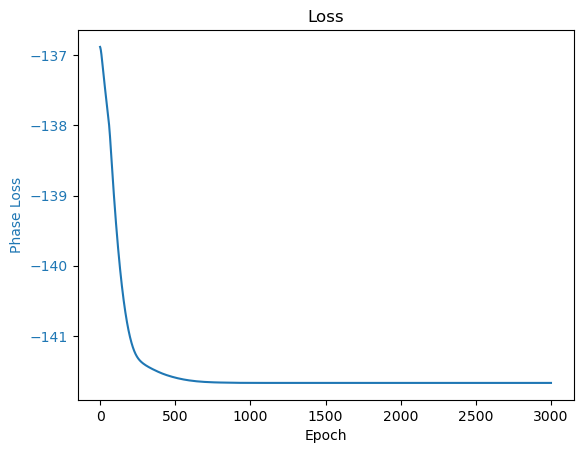

In [20]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()

In [21]:
one_hot_states = jnp.eye(visible_units, dtype=jnp.float32)
one_hot_bitstrings = [''.join('1' if s > 0 else '0' for s in state) for state in one_hot_states]

model_phases_raw = model_pha.apply({"params": state_pha.params, "amp": amp_vars}, one_hot_states, method=model_pha.compute_phase)
model_phases_norm = model_phases_raw - model_phases_raw[-3]
model_phases_wrapped = model_phases_norm % (2 * jnp.pi)

model_phase_tuples = sorted(zip(one_hot_bitstrings, model_phases_raw, model_phases_wrapped), key=lambda x: int(x[0], 2))

for bitstring, phase_raw, phase_wrapped in model_phase_tuples:
    print(f"{bitstring}: {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

00000001: 5.3375 (raw), 3.5430 (wrapped)
00000010: 4.8765 (raw), 3.0820 (wrapped)
00000100: 1.7945 (raw), 0.0000 (wrapped)
00001000: -0.3680 (raw), 4.1206 (wrapped)
00010000: 1.6427 (raw), 6.1314 (wrapped)
00100000: 1.3576 (raw), 5.8463 (wrapped)
01000000: -2.8067 (raw), 1.6820 (wrapped)
10000000: -3.9435 (raw), 0.5452 (wrapped)


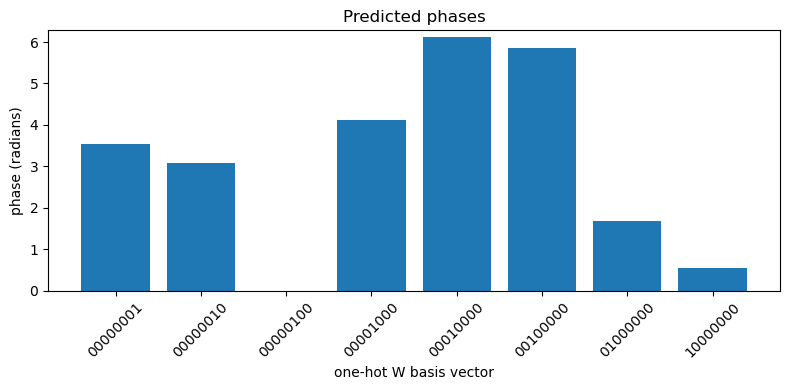

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([t[0] for t in model_phase_tuples], [t[2] for t in model_phase_tuples])
ax.set_xlabel("one-hot W basis vector")
ax.set_ylabel("phase (radians)")
ax.set_title("Predicted phases")
ax.set_ylim(0, 2 * jnp.pi)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
w_aug_file_path = Path(data_dir) / f"w_aug_{visible_units}.txt"
w_aug_state_dict = load_state_vector(w_aug_file_path)

phase_offset = np.angle(w_aug_state_dict[one_hot_bitstrings[-3]])

original_phase_tuples = []
for bs in sorted(one_hot_bitstrings, key=lambda x: int(x, 2)):

    amplitude = w_aug_state_dict[bs]
    phase_raw = np.angle(amplitude)  # get raw phase in radians
    phase_norm = phase_raw - phase_offset  # normalize by the last one-hot state
    phase_wrapped = phase_norm % (2 * jnp.pi)

    original_phase_tuples.append((bs, amplitude, phase_raw, phase_wrapped))

for bitstring, amp, phase_raw, phase_wrapped in original_phase_tuples:
    print(f"{bitstring}: {amp:.8f} (ampl), {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

00000001: 0.35348165+0.00712282j (ampl), 0.0201 (raw), 4.5136 (wrapped)
00000010: 0.34222963+0.08876304j (ampl), 0.2538 (raw), 4.7472 (wrapped)
00000100: -0.07679566+0.34511220j (ampl), 1.7898 (raw), 0.0000 (wrapped)
00001000: 0.02867402-0.35238871j (ampl), -1.4896 (raw), 3.0038 (wrapped)
00010000: 0.01964585+0.35300714j (ampl), 1.5152 (raw), 6.0086 (wrapped)
00100000: -0.03371835+0.35194188j (ampl), 1.6663 (raw), 6.1597 (wrapped)
01000000: -0.28657940-0.20705615j (ampl), -2.5159 (raw), 1.9775 (wrapped)
10000000: -0.13468251-0.32689542j (ampl), -1.9616 (raw), 2.5318 (wrapped)


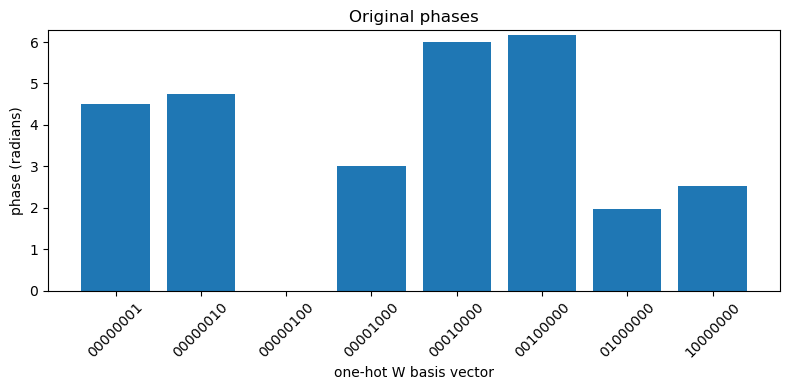

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([t[0] for t in original_phase_tuples], [t[3] for t in original_phase_tuples])
ax.set_xlabel("one-hot W basis vector")
ax.set_ylabel("phase (radians)")
ax.set_title("Original phases")
ax.set_ylim(0, 2 * jnp.pi)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()